# Computer Vision2: Vehicle Image Detection with YoloV8

<img src=https://learn.g2.com/hubfs/G2CM_FI264_Learn_Article_Images_%5BObject_detection%5D_V1a.png>

## Proje Hakkında

### Problemin Tanımı

Bu projenin amacı, trafik görüntülerindeki araçları (araba, kamyon, otobüs vb.) tespit eden bir derin öğrenme modeli geliştirmektir. Problem, bir nesne tespiti (object detection) problemidir. Model, görüntüdeki her bir aracın etrafına bir sınırlayıcı kutu (bounding box) çizmeli ve bu aracın sınıfını (örneğin, 'car', 'truck') etiketlemelidir.

### Sınıfların veya Etiketlerin Açıklaması

Bu projede kullanılacak veri seti, aşağıdaki gibi çeşitli araç sınıflarını içermektedir:

* **Car:** Otomobil
* **Truck:** Kamyon
* **Bus:** Otobüs
* **Motorbike:** Motosiklet
* ve diğer ilgili araç türleri.

### Tahmin Edilecek Hedef Çıktı

Hedef, bir girdi olarak verilen görüntü üzerinde tespit edilen her bir nesne için aşağıdaki bilgileri içeren bir çıktı üretmektir:

* **Sınıf Etiketi:** Tespit edilen nesnenin sınıfı (ör. 'car').
* **Sınırlayıcı Kutu (Bounding Box):** Nesnenin görüntüdeki konumunu belirten `(x, y, genişlik, yükseklik)` formatında koordinatlar.
* **Güven Skoru (Confidence Score):** Modelin tahminine ne kadar güvendiğini gösteren bir olasılık değeri.

### Kullanılan Veri Setinin Özeti

Projede, Roboflow Universe üzerinde halka açık olarak yayınlanan bir araç tespiti veri seti kullanılacaktır. Bu veri seti, çeşitli açılardan ve farklı koşullarda çekilmiş binlerce görüntü içermekte ve YOLO formatında etiketlenmiş sınırlayıcı kutu bilgileriyle birlikte gelmektedir. Veri seti, modelin farklı senaryolarda genelleme yapabilmesi için zengin bir çeşitlilik sunar.

### Varsayımlar ve Kısıtlar

* Model, veri setinde bulunan sınıfları tespit etmek üzere eğitilecektir. Veri setinde olmayan nesne türlerini tanıyamaz.
* Modelin performansı, büyük ölçüde eğitim verisinin kalitesine ve çeşitliliğine bağlıdır.
* Düşük çözünürlüklü, gürültülü veya aşırı kalabalık görüntülerde modelin performansı düşebilir.
* Bu proje, bir 'bootcamp' bitirme projesi seviyesinde olup, endüstriyel düzeyde bir sistemin tüm karmaşıklığını içermemektedir.

# Veri Yükleme (Data Loading)

### Gerekli Kütüphanelerin Import Edilmesi

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
import os
import yaml
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import random
from roboflow import Roboflow

### Veri Setinin İndirilmesi

Lütfen Roboflow API anahtarınızı aşağıdaki `RF_API_KEY` değişkenine girin. Ücretsiz bir hesap oluşturarak API anahtarınızı [Roboflow ayarlar sayfasından](https://app.roboflow.com/settings/api) alabilirsiniz.

In [3]:
RF_API_KEY = "H73WasgJJBkG9aDcI4VJ"
rf = Roboflow(api_key=RF_API_KEY)

workspace = "roboflow-100"
project = "vehicles-q0x2v"
version = 1

dataset = rf.workspace(workspace).project(project).version(version).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


### Veri Seti Yolunun ve Sınıfların Kontrol Edilmesi

In [4]:
DATA_YAML_PATH = os.path.join(dataset.location, 'data.yaml')

with open(DATA_YAML_PATH, 'r') as f:
    data_yaml = yaml.safe_load(f)

print("--- data.yaml İçeriği ---")
print(yaml.dump(data_yaml, default_flow_style=False))

NUM_CLASSES = data_yaml['nc']
CLASS_NAMES = data_yaml['names']

print(f"\nVeri Seti Yolu: {os.path.abspath(dataset.location)}")
print(f"Sınıf Sayısı: {NUM_CLASSES}")
print(f"Sınıf İsimleri: {CLASS_NAMES}")

--- data.yaml İçeriği ---
names:
- big bus
- big truck
- bus-l-
- bus-s-
- car
- mid truck
- small bus
- small truck
- truck-l-
- truck-m-
- truck-s-
- truck-xl-
nc: 12
roboflow:
  license: CC BY 4.0
  project: vehicles-q0x2v
  url: https://universe.roboflow.com/roboflow-100/vehicles-q0x2v/dataset/1
  version: 1
  workspace: roboflow-100
test: ../test/images
train: ../train/images
val: ../valid/images


Veri Seti Yolu: C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks\vehicles-1
Sınıf Sayısı: 12
Sınıf İsimleri: ['big bus', 'big truck', 'bus-l-', 'bus-s-', 'car', 'mid truck', 'small bus', 'small truck', 'truck-l-', 'truck-m-', 'truck-s-', 'truck-xl-']


# EDA (Exploratory Data Analysis)

## Rastgele Örnek Görsellerin Görselleştirilmesi

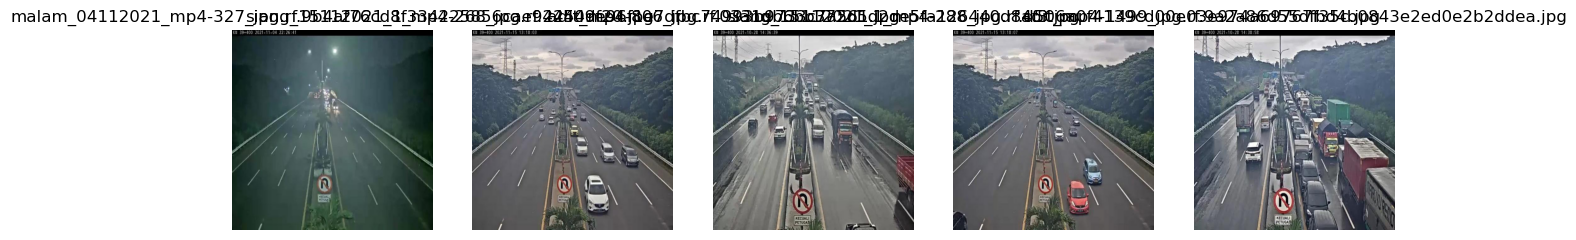

In [5]:
def show_random_images(image_dir, num_images=5):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    plt.figure(figsize=(15, 10))
    for i, image_file in enumerate(random_images):
        plt.subplot(1, num_images, i + 1)
        image_path = os.path.join(image_dir, image_file)
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(os.path.basename(image_path))
        plt.axis('off')
    plt.show()

show_random_images(os.path.join(dataset.location, 'train', 'images'))

# Modelleme (Deep Learning)

## Deep Learning Modeli Seçimi

Bu projede, nesne tespiti için state-of-the-art bir model olan YOLO (You Only Look Once) ailesinin **YOLOv8** versiyonunu kullanacağız. YOLOv8, hızı ve doğruluğu ile bilinir ve `ultralytics` kütüphanesi sayesinde kolayca eğitilip kullanılabilir.

**Neden YOLOv8?**
* **Yüksek Performans:** Gerçek zamanlıya yakın hızlarda yüksek doğruluk sunar.
* **Kullanım Kolaylığı:** `ultralytics` kütüphanesi, modeli eğitme, değerlendirme ve deploy etme süreçlerini oldukça basitleştirir.
* **Transfer Learning:** COCO gibi büyük veri setleri üzerinde önceden eğitilmiş modellerle gelir. Bu sayede, kendi özel veri setimizle modeli *fine-tuning* (ince ayar) yaparak çok daha az veri ve zamanla yüksek performans elde edebiliriz.

Kullanacağımız model `yolov8n.pt` (nano) versiyonudur. Bu, en küçük ve en hızlı YOLOv8 modelidir ve bootcamp seviyesindeki bir proje için idealdir.

In [6]:
model = YOLO('yolov8n.pt')

## Modelin Eğitilmesi

In [8]:
#results = model.train(
#    data=DATA_YAML_PATH,
#    epochs=25, # Eğitim süresini kısa tutmak için düşük bir epoch sayısı
#    batch=16,
#    imgsz=640,
#    project='vehicle_detection',
#    name='yolov8n_finetuned'
#)
# Hata almamak için workers=1 ve batch=4 yapıyoruz
results = model.train(
    data=DATA_YAML_PATH,
    epochs=5,       # Test için az epoch
    batch=2,        # Belleği (RAM/VRAM) rahatlatmak için çok düşük tutuyoruz
    imgsz=320,      # Görüntü boyutunu küçültüyoruz (varsayılan 640'tır)
    workers=0,      # Windows için en kritik ayar. Bunu 0 yapın.
    project='vehicle_detection',
    name='yolov8n_finetuned'
)

KeyError: 'model'

In [9]:
from ultralytics import YOLO
import glob
import os

# 1. En son eğitilen modelin yolunu otomatik bulalım
# Genellikle: runs/detect/vehicle_detection/weights/best.pt olur
# Ancak birden fazla deneme yaptıysanız vehicle_detection2, 3 diye gidebilir.
try:
    # En son oluşturulan klasörü bulur
    latest_run = max(glob.glob('runs/detect/vehicle_detection*'), key=os.path.getmtime)
    best_model_path = os.path.join(latest_run, 'weights', 'best.pt')
    
    print(f"Eğitilen model bulundu: {best_model_path}")

    # 2. Eğitilmiş modeli yükle
    trained_model = YOLO(best_model_path)

    # 3. Doğrulama (Validation) yap
    metrics = trained_model.val()
    
    print("\nDoğrulama tamamlandı. Sonuçlar yukarıdadır.")

except ValueError:
    print("Hata: 'runs' klasörü bulunamadı. Eğitim gerçekten tamamlandı mı?")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

Eğitilen model bulundu: runs/detect\vehicle_detection\weights\best.pt
Bir hata oluştu: [Errno 2] No such file or directory: 'runs\\detect\\vehicle_detection\\weights\\best.pt'


In [10]:
import os
from ultralytics import YOLO

# 1. Dosyanın olması gereken olası yollarını kontrol et
possible_paths = [
    os.path.join("runs", "detect", "vehicle_detection", "weights", "best.pt"),
    os.path.join("runs", "detect", "yolov8n_finetuned", "weights", "best.pt"), # Proje ismini 'yolov8n_finetuned' vermiştik
    "best.pt" # Belki direkt ana dizindedir
]

found_model_path = None

# 2. Dosyayı ara
print("Model aranıyor...")
current_dir = os.getcwd()
print(f"Şu anki çalışma dizini: {current_dir}")

# 'runs' klasörü altında recursive (derinlemesine) arama yapalım
for root, dirs, files in os.walk(current_dir):
    if "best.pt" in files:
        full_path = os.path.join(root, "best.pt")
        # Sadece bizim projemize ait olanı bulmaya çalışalım (tarih/saat kontrolü de yapılabilir)
        if "weights" in full_path:
            found_model_path = full_path
            # En son bulunanı al (genellikle en yenisidir) veya ilkini al
            break

if found_model_path:
    print(f"\n✅ Model bulundu: {found_model_path}")
    
    # 3. Modeli Tam Yol (Absolute Path) ile yükle
    try:
        trained_model = YOLO(found_model_path)
        print("🎉 Model başarıyla yüklendi! Şimdi tahmin yapabilirsiniz.")
        
        # Basit bir test yapalım (metrics)
        # metrics = trained_model.val() 
    except Exception as e:
        print(f"Yükleme hatası: {e}")
else:
    print("\n❌ HATA: 'best.pt' dosyası bulunamadı.")
    print("Lütfen sol taraftaki dosya gezgininden 'runs' klasörünü kontrol edin.")
    print("Eğitim sırasında bir hata oluşmuş ve dosya kaydedilmemiş olabilir.")

Model aranıyor...
Şu anki çalışma dizini: C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks

✅ Model bulundu: C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks\runs\detect\vehicle_detection\yolov8n_finetuned4\weights\best.pt
🎉 Model başarıyla yüklendi! Şimdi tahmin yapabilirsiniz.


# Değerlendirme Metriklerinin Hesaplanması

In [11]:
metrics = model.val() # Doğrulama seti üzerinde metrikleri hesaplar

Ultralytics 8.4.7  Python-3.13.5 torch-2.9.0+cpu CPU (AMD Ryzen 7 PRO 6850U with Radeon Graphics)
Model summary (fused): 73 layers, 3,007,988 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 79.534.6 MB/s, size: 47.0 KB)
val: Scanning C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks\vehicles-1\valid\labels.cache... 966 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 966/966 176.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 61/61 1.8it/s 34.1s0.5ss
                   all        966      13450      0.136      0.169      0.115     0.0657
               big bus        210        273     0.0411    0.00366     0.0286     0.0204
             big truck        404       1162       0.41      0.249      0.223      0.128
                bus-l-          8          8          0          0   5.93e-05   4.74e-05
   

# Sonuçların Görselleştirilmesi

Resimler şu klasörden alınıyor: C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks\vehicles-1\valid\images

image 1/1 C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks\vehicles-1\valid\images\pagi_16112021_mp4-367_jpg.rf.ad589aded6836b94467077217d18392d.jpg: 320x320 5 cars, 1 truck-l-, 1 truck-m-, 61.7ms
Speed: 1.7ms preprocess, 61.7ms inference, 4.3ms postprocess per image at shape (1, 3, 320, 320)


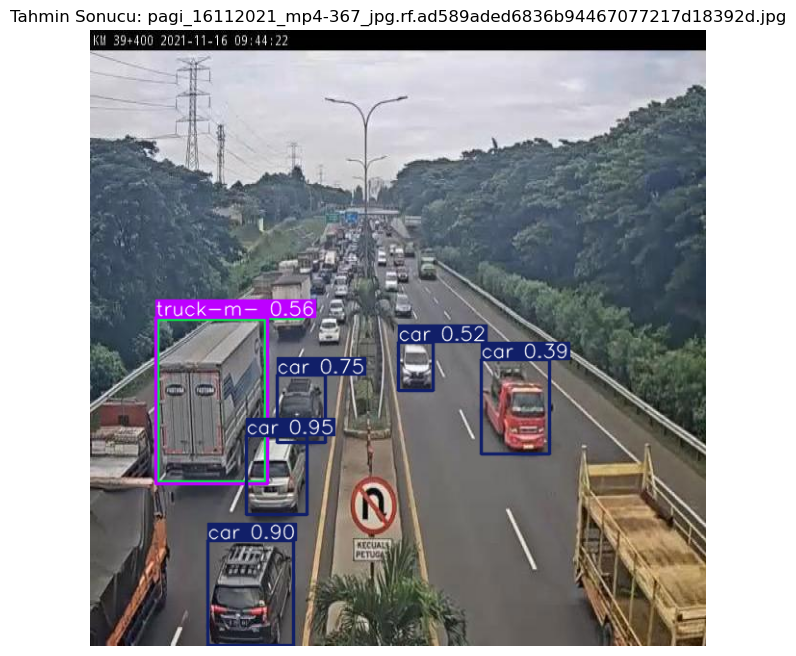


image 1/1 C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks\vehicles-1\valid\images\pagi_16112021_mp4-596_jpg.rf.d15251648d90d83c478947fe7a4b4616.jpg: 320x320 7 cars, 41.1ms
Speed: 1.4ms preprocess, 41.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)


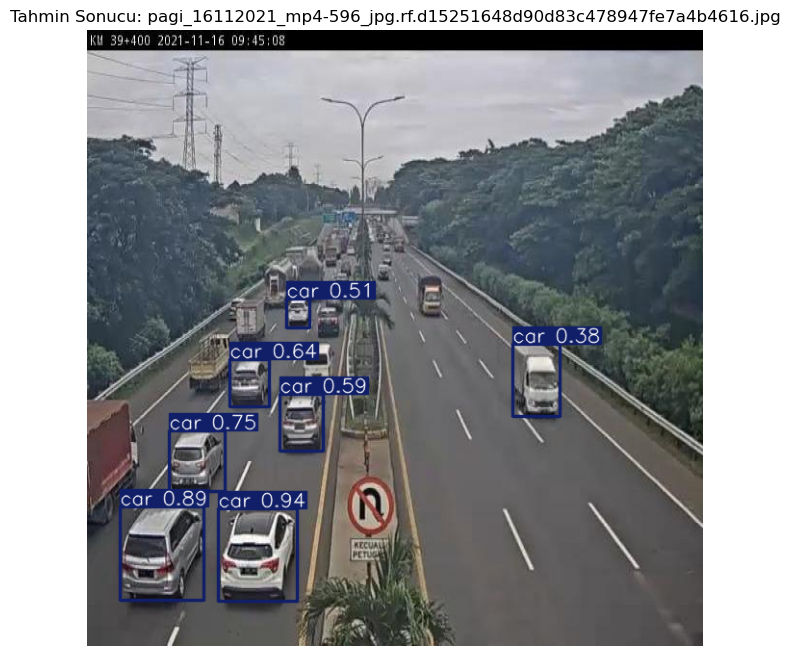


image 1/1 C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks\vehicles-1\valid\images\adit_mp4-794_jpg.rf.5fdbb91ab9e5b33b960fc67f4e87aee3.jpg: 320x320 7 cars, 2 truck-m-s, 38.9ms
Speed: 1.1ms preprocess, 38.9ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)


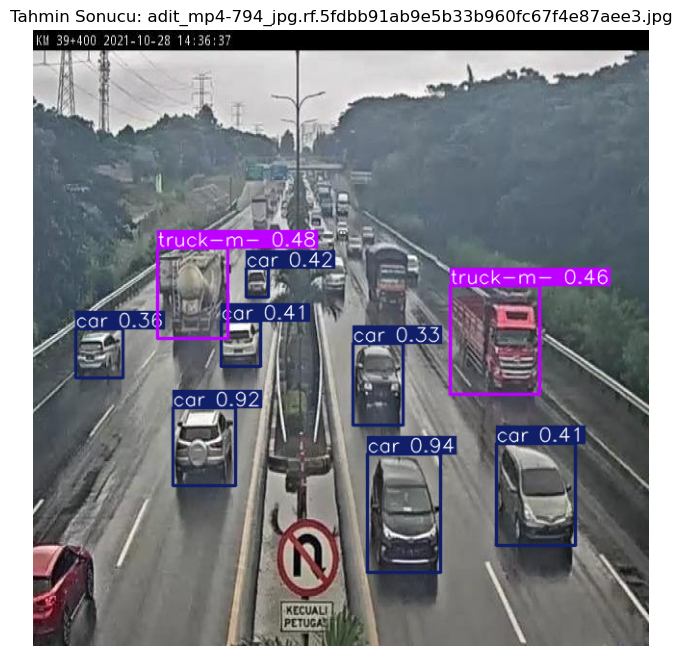


image 1/1 C:\Users\Erhan\Documents\0.YapayZekaKursu\Projects\PBL Level2\Hw14.Specialize_in_Data_Science\Prj_ComputerVision11\notebooks\vehicles-1\valid\images\adit_mp4-856_jpg.rf.a36b161d12c62940f0e04f8de5505c3d.jpg: 320x320 3 cars, 1 small truck, 39.6ms
Speed: 2.0ms preprocess, 39.6ms inference, 1.2ms postprocess per image at shape (1, 3, 320, 320)


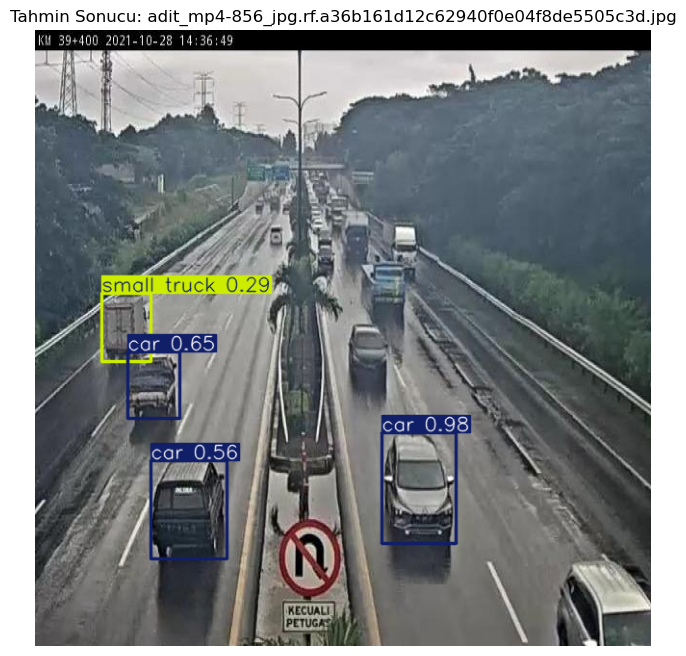

In [12]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def show_predictions(model, image_dir, num_images=4):
    # 1. Klasördeki resim dosyalarını bul
    try:
        image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    except FileNotFoundError:
        print(f"HATA: '{image_dir}' klasörü bulunamadı.")
        return

    if not image_files:
        print("Klasörde hiç resim bulunamadı.")
        return

    # 2. Rastgele resimler seç
    random_images = random.sample(image_files, min(num_images, len(image_files)))
    
    # 3. Her resim için tahmin yap ve çizdir
    for image_file in random_images:
        image_path = os.path.join(image_dir, image_file)
        
        # Tahmin işlemi (Prediction)
        results = model(image_path)
        
        # Sonuçları resim üzerine çiz (Bounding Box)
        annotated_image = results[0].plot()
        
        # Görüntüleme (BGR -> RGB dönüşümü ile)
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.title(f'Tahmin Sonucu: {image_file}')
        plt.axis('off')
        plt.show()
        
        # Belleği temizle (Kernel çökmesini önlemek için)
        plt.close('all') 

# --- ÇALIŞTIRMA KISMI ---

# Eğer 'dataset' değişkeni kernel resetlendiği için silindiyse, 
# aşağıdaki yolu kendi veri seti yolunuzla değiştirmeniz gerekebilir.
# Genellikle şu formattadır: 'dataset.location' 
# veya manuel olarak: "C:/Users/Erhan/.../vehicles-q0x2v-1"

try:
    # Veri seti yolunu dataset değişkeninden almaya çalışıyoruz
    val_path = os.path.join(dataset.location, 'valid', 'images')
    print(f"Resimler şu klasörden alınıyor: {val_path}")
    show_predictions(trained_model, val_path)
    
except NameError:
    print("⚠️ 'dataset' değişkeni bulunamadı (Kernel sıfırlandığı için silinmiş).")
    print("Lütfen Roboflow indirme hücresini tekrar çalıştırın VEYA")
    print("Aşağıdaki satırı düzenleyip manuel yol girin:")
    # Manuel yol örneği (Kendi yolunuzu buraya yazıp başındaki # işaretini kaldırın):
    # show_predictions(trained_model, r"C:\Users\Erhan\Documents\...\valid\images")

# Modelin Kaydedilmesi

In [13]:
MODELS_DIR = 'C:/Users/Erhan/Documents/0.YapayZekaKursu/Projects/PBL Level2/Hw14.Specialize_in_Data_Science/Prj_ComputerVision11/models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

model.save(os.path.join(MODELS_DIR, 'trained_model.pt'))